In [9]:
### The following block of code retrieves data from the datafile avia par in the data folder
#  Herefrom, all flights from the Netherlands (eg Rotterdam, Schiphol etc) to other airports in the world are retrieved
# Then, a new dataframe is made with every airportlocation that has a route to the Netherlands
# The geopy library is then used to look up the coordinates of every airport location, and the landcode
# A dataframe is the ouput of this block, with coordinates and and landcode per airport
# 
# the path should be changed to your path for file in the main datafolder - avia_par_nl -  data
# block takes about 10 min to execute because of retrievement from server with coordinates

import pandas as pd
from geopy.geocoders import Nominatim
from time import sleep
from geopy.exc import GeocoderTimedOut

# Path to the CSV file
file_path = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\avia_par_nl__custom_13210883_spreadsheet (csvformat).csv'

# Load the CSV file into a DataFrame using ';' as the separator
df = pd.read_csv(file_path, sep=';')

# Extract the first column and rename it to "Flight Route"
first_column = df.iloc[:, 0].rename("Flight Route")

# Create a new DataFrame for geocoding information (Flight Route, Coordinates, Land Code)
geo_df = pd.DataFrame({'Flight Route': first_column})

# Clean the 'Flight Route' column by removing unwanted prefixes and formatting the text
geo_df['Flight Route'] = geo_df['Flight Route'].astype(str)
geo_df['Flight Route'] = geo_df['Flight Route'].str.replace('AMSTERDAM/SCHIPHOL airport - ', '', regex=False)
geo_df['Flight Route'] = geo_df['Flight Route'].str.replace('Maastricht/Aachen airport - ', '', regex=False)
geo_df['Flight Route'] = geo_df['Flight Route'].str.replace('Eindhoven airport - ', '', regex=False)
geo_df['Flight Route'] = geo_df['Flight Route'].str.replace('Rotterdam airport - ', '', regex=False)
geo_df['Flight Route'] = geo_df['Flight Route'].str.replace('Groningen Eelde airport - ', '', regex=False)
geo_df['Flight Route'] = geo_df['Flight Route'].str.title().str.strip()

# Initialize the geolocator with a user agent to avoid request issues
geolocator = Nominatim(user_agent="airport_geolocator")

# Function to get the coordinates of the airport
def get_airport_coordinates(airport_name):
    try:
        location = geolocator.geocode(airport_name)
        if location:
            return (location.latitude, location.longitude)
        else:
            retry_query = f"{airport_name} Airport"
            location = geolocator.geocode(retry_query)
            if location:
                return (location.latitude, location.longitude)
            else:
                return (None, None)
    except:
        return (None, None)

# Add a delay between requests to avoid overwhelming the geocoding service
def get_coordinates_with_delay(airport_name):
    coords = get_airport_coordinates(airport_name)
    sleep(0.05)  # Add a delay between requests
    return coords

# Function to get the land code (country code) based on coordinates
def get_land_code(lat, lon):
    if pd.notna(lat) and pd.notna(lon):
        try:
            location = geolocator.reverse((lat, lon), language='en', timeout=10)
            if location and 'country_code' in location.raw['address']:
                return location.raw['address']['country_code'].upper()  # Return country code in uppercase
            else:
                return None
        except GeocoderTimedOut:
            return None
    else:
        return None

# Apply the function to the 'Flight Route' column to get coordinates and land codes
geo_df['Coordinates'] = geo_df['Flight Route'].apply(get_coordinates_with_delay)
geo_df[['Latitude', 'Longitude']] = pd.DataFrame(geo_df['Coordinates'].tolist(), index=geo_df.index)
geo_df['Land Code'] = geo_df.apply(lambda row: get_land_code(row['Latitude'], row['Longitude']), axis=1)

# Drop the original 'Coordinates' column for clarity
geo_df = geo_df.drop(columns=['Coordinates'])

# Remove duplicate rows
geo_df = geo_df.drop_duplicates()

# Display the DataFrame with Flight Route, Coordinates, and Land Code
print(geo_df[['Flight Route', 'Latitude', 'Longitude', 'Land Code']].to_string(index=False))

# Save this geo_df as a CSV or continue using it in memory
geo_df.to_csv('geo_data.csv', index=False)  # Optional: Save the geo data for future use



                                                           Flight Route   Latitude   Longitude Land Code
                                                       Airp_Pr (Labels)        NaN         NaN      None
                                        Abu Dhabi International Airport  24.431899   54.641977        AE
                                            Dubai International Airport  25.252129   55.365716        AE
                                               Bonaire/Flamingo Airport  12.131027  -68.264918        NL
                                        Curacao/Aeropuerto Hato Airport  12.189053  -68.962162        NL
                                   St. Maarten/Princess Juliana Airport  18.040874  -63.111852        NL
                                 Ezeiza Ministro Pistarini (Ba) Airport        NaN         NaN      None
                                                      Innsbruck Airport  47.259726   11.341871        AT
                                                 Wien-S

In [10]:
## this block calculates the distance from the Netherlands (central point amersfoort) to each airport location with coordinates.
# to calculate distance from netherlands coordinate to concerning airport coordinate, geopy is used
# then the passenger data is also put in the dataframe. Herewith the amount of passenger-kilometres is calculated
# Then, the amount of passenger kilometres is multiplied by the emission factor to get total CO2 emissions
# the flight time is also calculated by using the average speed over the calculated distance, and optionally also add extra flight delays
# also, the flights are categorized in flight distance, as short haul flights are relatively more polluting.

# In this block, change the path to the emission data file - carbon footprint etc-

import pandas as pd
from geopy.distance import geodesic

# Load the geo_df DataFrame (assume this is already loaded)
# geo_df = pd.read_csv('geo_data.csv')  # Uncomment if loading from a saved file

# Extract the last column from the original data and rename it to "2024 Q2 Total Passengers"
last_column = df.iloc[:, -1].rename("2024 Q2 Total Passengers")

# Merge geo_df with the passengers data to create the final DataFrame
final_df = pd.DataFrame({
    'Flight Route': geo_df['Flight Route'],
    '2024 Q2 Total Passengers': last_column
})

# Merge with the geo data (coordinates and land codes)
final_df = pd.merge(final_df, geo_df[['Flight Route', 'Latitude', 'Longitude', 'Land Code']], on='Flight Route', how='left')

# Define the coordinates for the most central point in the Netherlands (Amersfoort)
central_netherlands_coords = (52.1561, 5.3878)

# Function to calculate the distance from the central point in the Netherlands to each airport
def calculate_distance_to_netherlands(lat, lon):
    if pd.notna(lat) and pd.notna(lon):
        return geodesic(central_netherlands_coords, (lat, lon)).kilometers
    else:
        return None

# Calculate the distance to the Netherlands for each airport
final_df['Distance to Netherlands (km)'] = final_df.apply(
    lambda row: calculate_distance_to_netherlands(row['Latitude'], row['Longitude']), axis=1
)

# Dictionary of known distances to Amersfoort, Netherlands for specific airports
known_distances = {
    "Montreal/Pierre Elliot Trudeau Intl, Qc Airport": 5560,
    "Toronto/Lester B. Pearson Intl, On Airport": 6000,
    "Hannover Uir Airport": 300,
    "Zagreb/Franjo Tudjman Airport": 1100,
    "Bangalore International Airport, Devenahalli, Bangalore Airport": 7800,
    "Tehran/Imam Khomaini Intl Airport": 4400,
    "Nairobi Acc,Fic,Rcc,Com Airport": 6500,
    "Luftfartstilsynet Civil Aviation Authority Airport": 1100,
    "Enfidha Zine El Abidine Ben Ali Airport": 1900,
    "Taibei City/Taibei Intl Ap Airport": 9500,
    "Kilimanjaro App, Twr, Ais, Met, Civil Airlines Airport": 7000,
    "Boston/General Edward Lawrence Logan International, Ma. Airport": 5600,
    "Washington Dulles International, Dc. Airport": 6200,
    "Maiquetia, Intl, Simon Bolivar, Vargas Airport": 7600,
    "Maastricht/Aachen Airport - Kos/Ippokratis Airport": 2100,
    "Maastricht/Aachen Airport - Zakinthos/Dionisios Solomos Airport": 2300,
    "Eindhoven Airport - Athinai/Eleftherios Venizelos Airport": 2200,
    "Eindhoven Airport - Kos/Ippokratis Airport": 2100,
    "Eindhoven Airport - Zagreb/Franjo Tudjman Airport": 1100,
    "Eindhoven Airport - Oujda/Angads Airport": 1900,
    "Eindhoven Airport - Nador/El Aroui Airport": 1900,
    "Groningen/Eelde Airport - Kos/Ippokratis Airport": 2100,
    "Rotterdam Airport - Kos/Ippokratis Airport": 2100,
    "Rotterdam Airport - Bergerac-Roumaniere Airport": 800,
    "Rotterdam Airport - Nador/El Aroui Airport": 1900,
}

# Update the distance in the DataFrame if it is NaN and has a known value in the dictionary
final_df['Distance to Netherlands (km)'] = final_df.apply(
    lambda row: known_distances[row['Flight Route']] if pd.isna(row['Distance to Netherlands (km)']) and row['Flight Route'] in known_distances else row['Distance to Netherlands (km)'],
    axis=1
)

# Remove duplicate rows from the DataFrame
final_df = final_df.drop_duplicates()

# Clean '2024 Q2 Total Passengers' column
final_df['2024 Q2 Total Passengers'] = final_df['2024 Q2 Total Passengers'].replace(',', '', regex=True)
final_df['2024 Q2 Total Passengers'] = pd.to_numeric(final_df['2024 Q2 Total Passengers'], errors='coerce')

# Create a new column that multiplies total passengers by distance to the Netherlands
final_df['Passenger Distance Product'] = final_df.apply(
    lambda row: row['2024 Q2 Total Passengers'] * row['Distance to Netherlands (km)']
    if pd.notna(row['2024 Q2 Total Passengers']) and pd.notna(row['Distance to Netherlands (km)'])
    else 'N/A',
    axis=1
)

# Create a new column for distance categories based on the distance to the Netherlands
def categorize_distance(distance):
    if pd.isna(distance):
        return 'N/A'
    elif distance < 1000:
        return 'Short'
    elif 1000 <= distance <= 5000:
        return 'Middle'
    else:
        return 'Long'

final_df['distancecategory'] = final_df['Distance to Netherlands (km)'].apply(categorize_distance)

# Load the emission factors from the CSV file
emission_factors_path = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\carbon-footprint-travel-mode.csv'
emission_df = pd.read_csv(emission_factors_path)

# Extract emission factors
short_flight_factor = emission_df.iloc[-2, -1]  # Penultimate row for short flights
middle_flight_factor = emission_df.iloc[5, -1]  # 6th row for middle flights
long_flight_factor = emission_df.iloc[10, -1]  # 11th row for long flights

# Map emission factors based on the distance category
emission_factors = {'Short': short_flight_factor, 'Middle': middle_flight_factor, 'Long': long_flight_factor}
final_df['Emission Factor (g CO2/pax-km)'] = final_df['distancecategory'].map(emission_factors)

# Convert relevant columns to numeric
final_df['Passenger Distance Product'] = pd.to_numeric(final_df['Passenger Distance Product'], errors='coerce')
final_df['Emission Factor (g CO2/pax-km)'] = pd.to_numeric(final_df['Emission Factor (g CO2/pax-km)'], errors='coerce')

# Create a new column for total CO2 emissions for all passengers in tonnes
final_df['Total CO2 Emissions (tonnes, all passengers)'] = final_df.apply(
    lambda row: (row['Passenger Distance Product'] * row['Emission Factor (g CO2/pax-km)'] / 1_000_000)
    if pd.notna(row['Passenger Distance Product']) and pd.notna(row['Emission Factor (g CO2/pax-km)'])
    else 'N/A',
    axis=1
)

# Function to calculate flight time
def calculate_flight_time(distance, avg_speed, pre_flight_time):
    if pd.notna(distance) and distance > 0 and avg_speed > 0:
        flight_time = distance / avg_speed  # Time = Distance / Speed
        total_time = flight_time + pre_flight_time  # Add pre-flight time
        return total_time
    else:
        return None

# Example inputs for speed and pre-flight time
avg_speed = 800  # Example average speed in km/h
pre_flight_time = 1.5  # Example pre-flight time in hours

# Calculate the flight time for each row
final_df['Flight Time (hours)'] = final_df['Distance to Netherlands (km)'].apply(
    lambda x: calculate_flight_time(x, avg_speed, pre_flight_time)
)

# Display the final DataFrame with all relevant columns
print(final_df[['Flight Route', '2024 Q2 Total Passengers', 'Latitude', 'Longitude', 'Distance to Netherlands (km)', 'Passenger Distance Product', 'distancecategory', 'Emission Factor (g CO2/pax-km)', 'Total CO2 Emissions (tonnes, all passengers)', 'Flight Time (hours)']].to_string(index=False))



                                                           Flight Route  2024 Q2 Total Passengers   Latitude   Longitude  Distance to Netherlands (km)  Passenger Distance Product distancecategory  Emission Factor (g CO2/pax-km) Total CO2 Emissions (tonnes, all passengers)  Flight Time (hours)
                                                       Airp_Pr (Labels)                       NaN        NaN         NaN                           NaN                         NaN              N/A                             NaN                                          N/A                  NaN
                                        Abu Dhabi International Airport                   53133.0  24.431899   54.641977                   5150.168866                2.736439e+08             Long                          113.55                                 31072.267386             7.937711
                                            Dubai International Airport                  224942.0  25.252129   55.3657

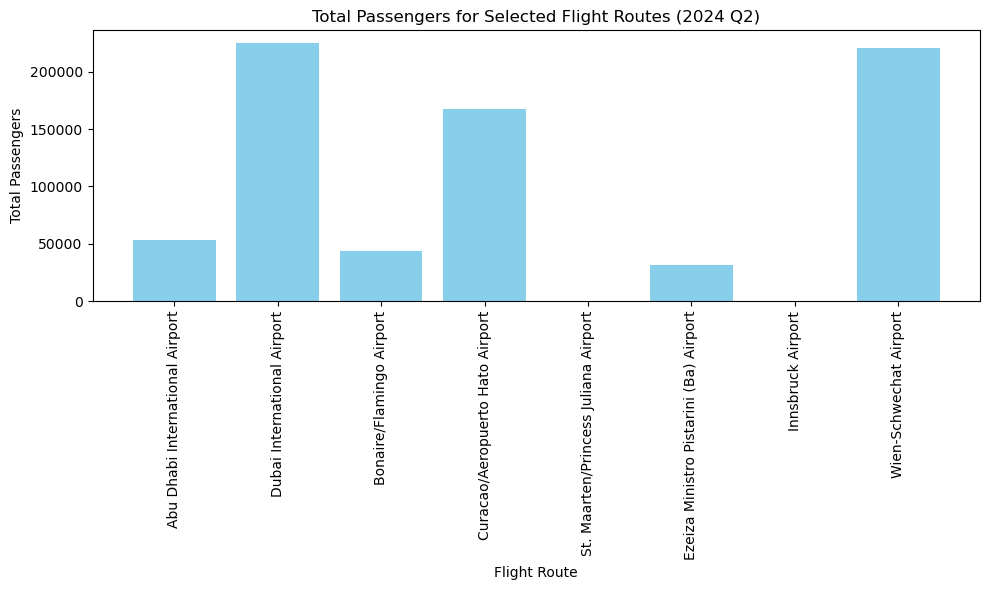

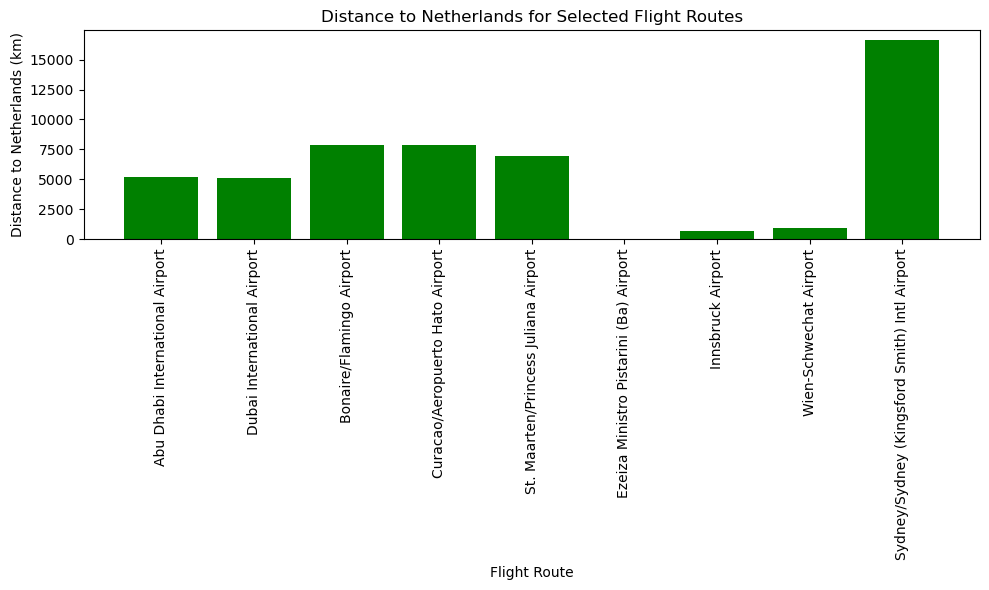

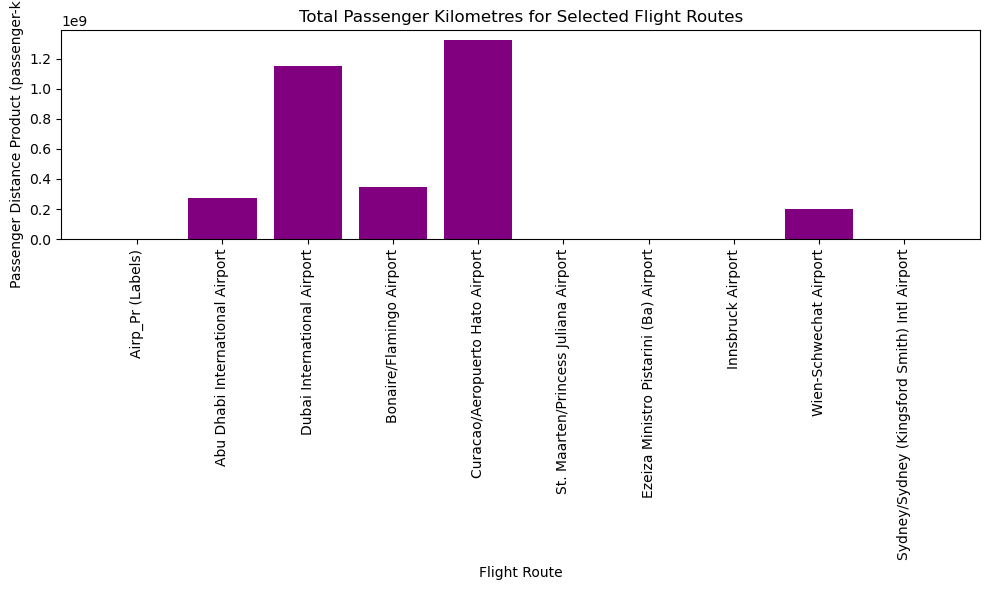

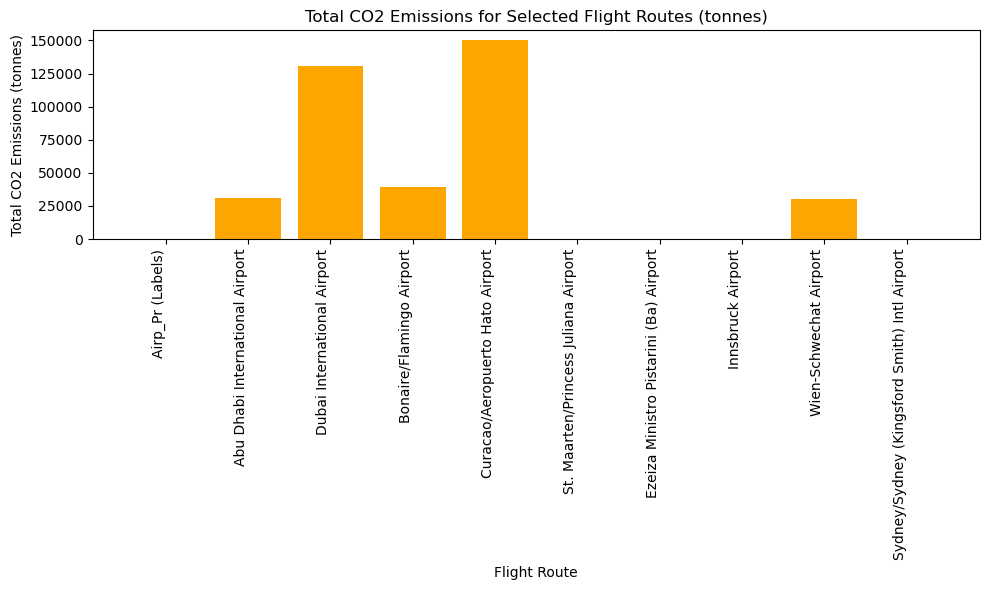

In [11]:
#in this block we make charts and show graphs etc

import matplotlib.pyplot as plt
import pandas as pd

# Ensure the 'Total CO2 Emissions (tonnes, all passengers)' is numeric and handle NaN values
final_df['Total CO2 Emissions (tonnes, all passengers)'] = pd.to_numeric(final_df['Total CO2 Emissions (tonnes, all passengers)'], errors='coerce').fillna(0)

# Ensure 'Passenger Distance Product' is also numeric and handle NaN values
final_df['Passenger Distance Product'] = pd.to_numeric(final_df['Passenger Distance Product'], errors='coerce').fillna(0)

# Select a subset of locations to compare (you can adjust this as needed)
locations_to_compare = final_df['Flight Route'].unique()[:10]  # Example: comparing the first 10 locations

# Filter the DataFrame to only include the selected locations
df_to_compare = final_df[final_df['Flight Route'].isin(locations_to_compare)]

# Bar chart for total passengers comparison
plt.figure(figsize=(10, 6))
plt.bar(df_to_compare['Flight Route'], df_to_compare['2024 Q2 Total Passengers'], color='skyblue')
plt.title('Total Passengers for Selected Flight Routes (2024 Q2)')
plt.xlabel('Flight Route')
plt.ylabel('Total Passengers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for distance to Netherlands (km) comparison
plt.figure(figsize=(10, 6))
plt.bar(df_to_compare['Flight Route'], df_to_compare['Distance to Netherlands (km)'], color='green')
plt.title('Distance to Netherlands for Selected Flight Routes')
plt.xlabel('Flight Route')
plt.ylabel('Distance to Netherlands (km)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for total passenger kilometres (Passenger Distance Product)
plt.figure(figsize=(10, 6))
plt.bar(df_to_compare['Flight Route'], df_to_compare['Passenger Distance Product'], color='purple')
plt.title('Total Passenger Kilometres for Selected Flight Routes')
plt.xlabel('Flight Route')
plt.ylabel('Passenger Distance Product (passenger-km)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for total CO2 emissions (tonnes) comparison with vertical x-axis labels
plt.figure(figsize=(10, 6))
plt.bar(df_to_compare['Flight Route'], df_to_compare['Total CO2 Emissions (tonnes, all passengers)'], color='orange')
plt.title('Total CO2 Emissions for Selected Flight Routes (tonnes)')
plt.xlabel('Flight Route')
plt.ylabel('Total CO2 Emissions (tonnes)')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels vertically
plt.tight_layout()
plt.show()


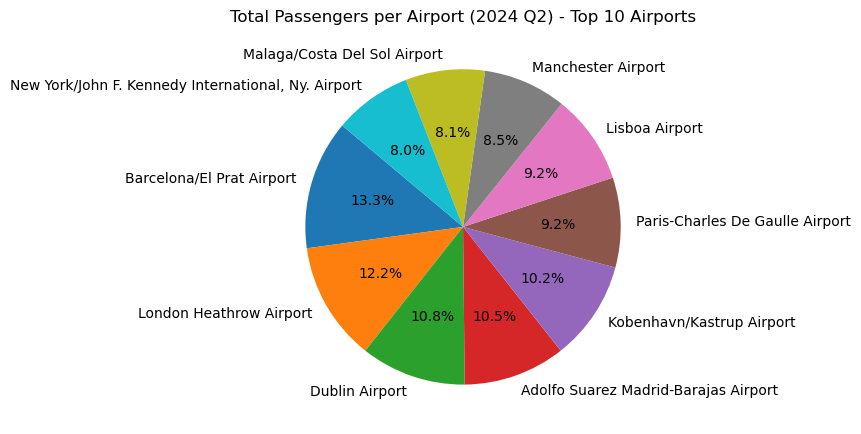

In [12]:
#This block of code generates a pie chart showing the distribution of total passengers across the top 10 airports (flight routes) from the Netherlands during 2024 Q2.
# Ensure the '2024 Q2 Total Passengers' is numeric and handle NaN values
final_df['2024 Q2 Total Passengers'] = pd.to_numeric(final_df['2024 Q2 Total Passengers'], errors='coerce').fillna(0)

# Sort the DataFrame by total passengers
df_sorted = final_df.sort_values(by='2024 Q2 Total Passengers', ascending=False)

# Limit to top 10 airports for better visualization (optional)
df_top_10 = df_sorted.head(10)

# Pie chart for total passengers per airport (Top 10)
plt.figure(figsize=(8, 8))
plt.pie(df_top_10['2024 Q2 Total Passengers'], labels=df_top_10['Flight Route'], autopct='%1.1f%%', startangle=140)
plt.title('Total Passengers per Airport (2024 Q2) - Top 10 Airports')
plt.tight_layout()
plt.show()


In [13]:
#in this block, we retrieve the amount of passengers for 2022 from another datafile
# in this block, the flight data from 2022 is used, here we only calculate the distance from a specific file
#adjust the paths below accordingly; first one should be file final data, second one in the data under the directory 'Flight Netherlands


import pandas as pd

pd.set_option('display.width', 1000)  # Adjust the width as necessary
pd.set_option('display.max_columns', None)  # Ensure that all columns are displayed


# Paths to your CSV files
file_final_data = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\final_data.csv'
file_path = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\Flight Netherlands\avia_par_nl__custom_13280147_spreadsheet.csv'

# Load the final data CSV (Flight Route, Land Code, and Distance to Netherlands)
df_final = pd.read_csv(file_final_data)

# Extract the first column ('Flight Route'), second-to-last column ('Land Code'), and the last column ('Distance to Netherlands (km)')
df_extracted = df_final.iloc[:, [0, -2, -1]]  # First, second-to-last, and last columns
df_extracted.columns = ['Flight Route', 'Land Code', 'Distance to Netherlands (km)']  # Rename columns

# Skip the first 4 rows (2 initial rows and 2 more rows), and the last two rows, then reset the index
df_extracted_cut = df_extracted.iloc[4:-2].reset_index(drop=True)

# Load the CSV file with ';' as the separator, and skip the first 10 rows
df = pd.read_csv(file_path, sep=';', skiprows=10)

# Assign meaningful column names to only the relevant columns, ignoring the 'Unnamed' columns
df.columns = ['Flight Route', '2010', 'Unnamed_2', '2011', 'Unnamed_4', '2012', 'Unnamed_6', 
              '2013', 'Unnamed_8', '2014', 'Unnamed_10', '2015', 'Unnamed_12', '2016', 'Unnamed_14', 
              '2017', 'Unnamed_16', '2018', 'Unnamed_18', '2019', 'Unnamed_20', '2020', 'Unnamed_22', 
              '2021', 'Unnamed_24', '2022', 'Unnamed_26', '2023', 'Unnamed_28']

# Extract the 'Flight Route' and '2022' columns
df_2022 = df[['Flight Route', '2022']].copy()

# Replace commas in the '2022' column and convert to numeric while keeping NaNs
df_2022['2022'] = df_2022['2022'].str.replace(',', '', regex=False)
df_2022['2022'] = pd.to_numeric(df_2022['2022'], errors='coerce')

# Fill missing values with a placeholder (e.g., 0 or 'N/A') to avoid skipping rows
df_2022['2022'] = df_2022['2022'].fillna('N/A')

# Skip the first two rows and cut the last 5 rows from df_2022
df_2022_cut = df_2022.iloc[2:-5].reset_index(drop=True)

# Combine the two dataframes
df_combined = pd.DataFrame({
    'Flight Route': df_extracted_cut['Flight Route'],
    'Land Code': df_extracted_cut['Land Code'],  # Include the 'Land Code' column
    'Distance to Netherlands (km)': df_extracted_cut['Distance to Netherlands (km)'],
    'Passengers 2022': df_2022_cut['2022']  # Adding the '2022' passengers column
})

# Display the resulting DataFrame
print(df_combined)


                                    Flight Route Land Code  Distance to Netherlands (km) Passengers 2022
0                Curacao/Aeropuerto Hato Airport        NL                   7879.480192        671781.0
1           St. Maarten/Princess Juliana Airport        NL                   6980.201827         80203.0
2         Ezeiza Ministro Pistarini (Ba) Airport       NaN                           NaN        108080.0
3                              Innsbruck Airport        AT                    693.064730         78207.0
4                         Wien-Schwechat Airport        AT                    917.280610        611758.0
..                                           ...       ...                           ...             ...
494  Rotterdam Airport - London Heathrow Airport       NaN                           NaN             N/A
495        Rotterdam Airport - Edinburgh Airport       NaN                           NaN        112276.0
496  Rotterdam Airport - London Stansted Airport       

In [3]:
import pandas as pd

#In this block we Summing passengers per Land Code for flight data
#This block of code processes passenger data for flights and all transport modes (e.g., flights, trains, buses, etc.) and merges them to give a total count of passengers per country (Land Code) for the year 2022.

#adjust the paths accordingly

# Grouping by Land Code and summing passengers for flights
df_flight_passengers = df_combined.groupby('Land Code').agg({
    'Passengers 2022': lambda x: pd.to_numeric(x, errors='coerce').sum(),
    'Distance to Netherlands (km)': 'first'  # Keeping one distance value per Land Code
}).reset_index()

df_flight_passengers.columns = ['Land Code', 'Total Passengers (Flight)', 'Distance to Netherlands (km)']

# Step 2: Summing passengers per Land Code for all transport modes from the new code

# File paths to the CSV files
file_path_from = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\Total Netherlands\fromNETHERLANDStin00190__custom_13279142_linear.csv'
file_path_to = r'C:\Users\omniq\Documents\GitHub\TIL6022-LabAssignments\Flytax-Project-Group24\CO2-effect\Data\Total Netherlands\toNETHERLANDStin00190__custom_13278956_linear.csv'

# Load both CSV files
df_from = pd.read_csv(file_path_from)
df_to = pd.read_csv(file_path_to)

# Create filtered dataframes with the relevant columns
filtered_df_from = df_from[['c_dest', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'c_dest': 'Land Code', 'OBS_VALUE': 'Passengers From'})
filtered_df_to = df_to[['geo', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'geo': 'Land Code', 'OBS_VALUE': 'Passengers To'})

# Group by 'TIME_PERIOD' and 'Land Code' for both datasets and sum the 'OBS_VALUE'
grouped_sum_df_from = filtered_df_from.groupby(['TIME_PERIOD', 'Land Code']).agg({'Passengers From': 'sum'}).reset_index()
grouped_sum_df_to = filtered_df_to.groupby(['TIME_PERIOD', 'Land Code']).agg({'Passengers To': 'sum'}).reset_index()

# Merge the two datasets based on 'TIME_PERIOD' and 'Land Code'
merged_df_transport = pd.merge(grouped_sum_df_from, grouped_sum_df_to, on=['TIME_PERIOD', 'Land Code'], how='outer')

# Fill NaN values with 0 for missing data in either dataset
merged_df_transport['Passengers From'] = merged_df_transport['Passengers From'].fillna(0)
merged_df_transport['Passengers To'] = merged_df_transport['Passengers To'].fillna(0)

# Calculate the total passengers by summing the two columns
merged_df_transport['Total Passengers (All Transport Modes)'] = merged_df_transport['Passengers From'] + merged_df_transport['Passengers To']

# Step 3: Filter the merged dataset for the year 2022
merged_df_transport_2022 = merged_df_transport[merged_df_transport['TIME_PERIOD'] == 2022]

# Step 4: Merge the two datasets based on 'Land Code' to get the final DataFrame

# Merging flight passengers with total transport passengers for 2022 based on Land Code
df_final_combined = pd.merge(
    df_flight_passengers,  # DataFrame with flight passengers
    merged_df_transport_2022[['Land Code', 'Total Passengers (All Transport Modes)']],  # DataFrame with total transport passengers
    on='Land Code',  # Merge based on Land Code
    how='inner'  # Only keep Land Codes present in both datasets
)

# Step 5: Display the final DataFrame
print(df_final_combined)


   Land Code  Total Passengers (Flight)  Distance to Netherlands (km)  Total Passengers (All Transport Modes)
0         AT                   689965.0                    693.064730                               1484845.0
1         BE                   173199.0                    153.368680                               3746473.0
2         BG                    94251.0                   1970.177685                                 68380.0
3         CH                  1165402.0                    660.273578                                698766.0
4         CY                        0.0                   2949.812230                                 43152.0
5         CZ                   447185.0                    662.125172                                282784.0
6         DE                  2770790.0                    553.268960                               9349517.0
7         DK                   469190.0                    469.461209                                327702.0
8         

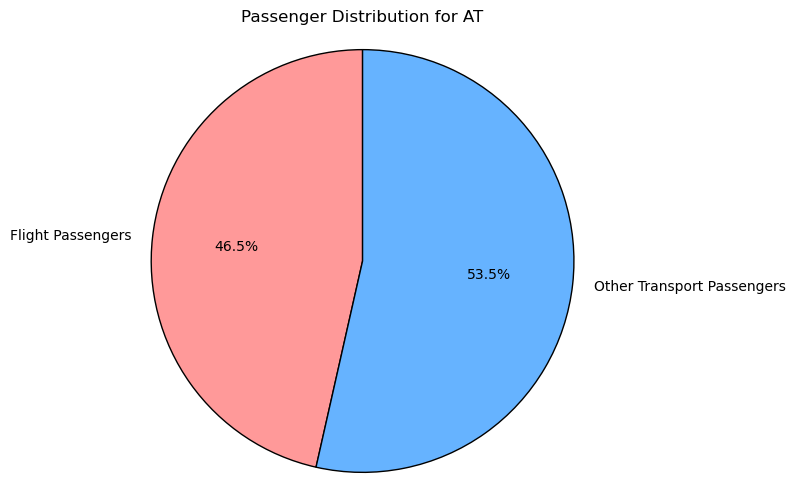

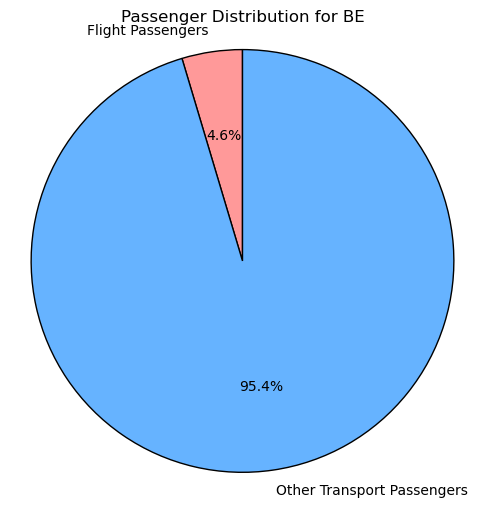

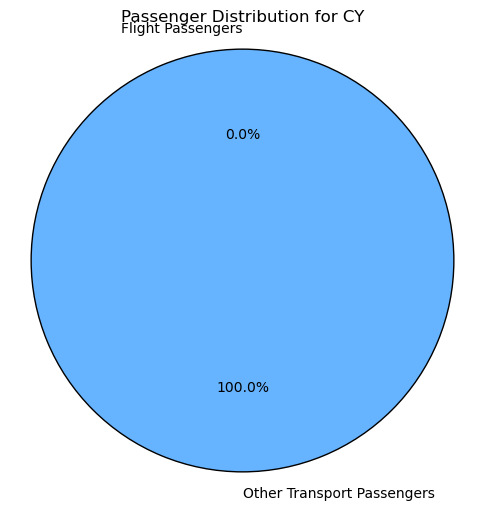

In [14]:
### here we plot the total passengers towards the passengers per airplane
#we see however that the data is not totally correct unfortunately
#In the next block of code I let chatgpt create data that is more realistic to make nicer charts
#so one thing in the report is to value and describe the data used, and why it is (not)good

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_final_combined is your DataFrame
# Remove rows where total passengers (for either category) are non-positive
df_final_combined = df_final_combined[(df_final_combined['Total Passengers (Flight)'] >= 0) & 
                                      (df_final_combined['Total Passengers (All Transport Modes)'] > 0)]

# Loop through only the first 4 Land Codes to create pie charts
for index, row in df_final_combined.head(6).iterrows():  # Limit to the first 4 rows
    land_code = row['Land Code']
    flight_passengers = row['Total Passengers (Flight)']
    total_passengers = row['Total Passengers (All Transport Modes)']

    # Ensure there are enough passengers to create the pie chart
    if total_passengers > flight_passengers >= 0:
        sizes = [flight_passengers, total_passengers - flight_passengers]
        labels = ['Flight Passengers', 'Other Transport Passengers']

        # Create the pie chart
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
                colors=['#ff9999', '#66b3ff'], wedgeprops={'edgecolor': 'black'})
        plt.title(f'Passenger Distribution for {land_code}')
        plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

        # Show the pie chart
        plt.show()





   Land Code  Total Passengers (Flight)  Adjusted Total Passengers (All Transport Modes)  Distance to Netherlands (km)
0         AT                   689965.0                                          1500000                    693.064730
1         BE                   173199.0                                          4000000                    153.368680
2         BG                    94251.0                                           700000                   1970.177685
3         CH                  1165402.0                                          2000000                    660.273578
4         CY                        0.0                                           500000                   2949.812230
5         CZ                   447185.0                                          1500000                    662.125172
6         DE                  2770790.0                                         10000000                    553.268960
7         DK                   469190.0         

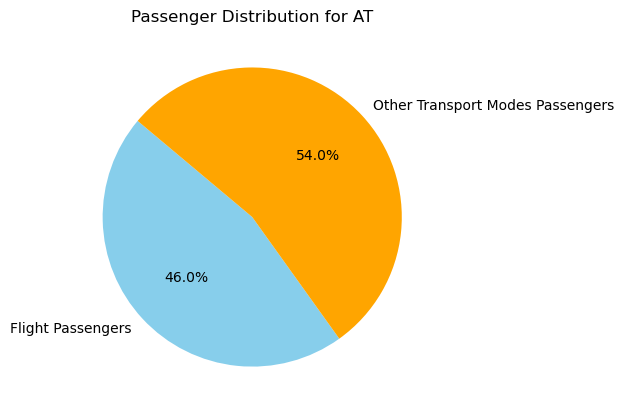

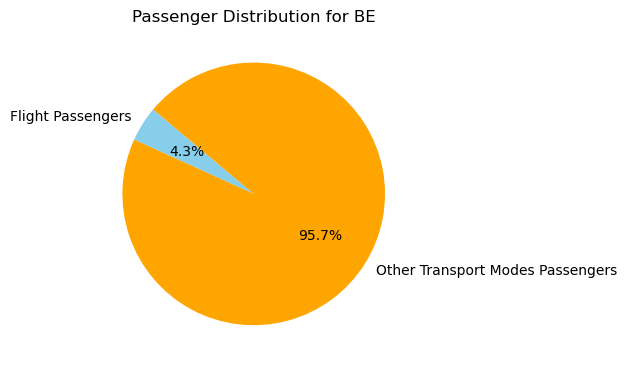

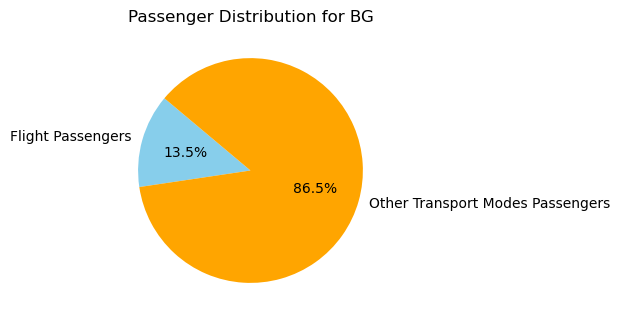

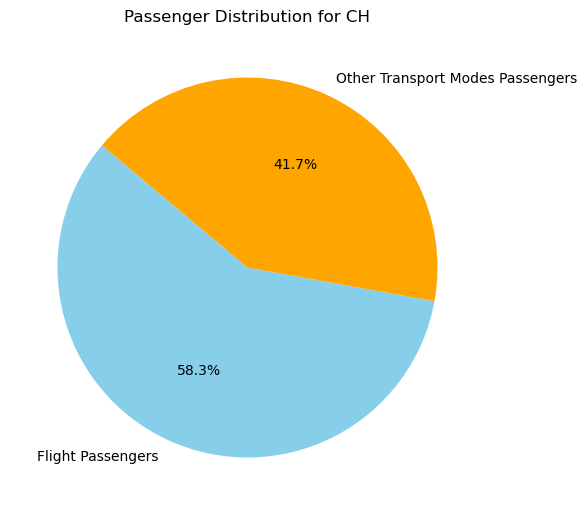

In [15]:
#here I manually adjust the total passengers per country and make the charts again


import pandas as pd

# Assuming df_final_combined is the DataFrame with the output

# Function to adjust the total passengers for all transport modes
def adjust_total_passengers_manual(row):
    land_code = row['Land Code']
    total_flight_passengers = row['Total Passengers (Flight)']
    
    # Manually adjust the total passengers for all transport modes based on assumptions
    if land_code == 'AT':  # Austria
        return 1500000
    elif land_code == 'BE':  # Belgium
        return 4000000
    elif land_code == 'BG':  # Bulgaria
        return 700000
    elif land_code == 'CH':  # Switzerland
        return 2000000
    elif land_code == 'CY':  # Cyprus
        return 500000
    elif land_code == 'CZ':  # Czech Republic
        return 1500000
    elif land_code == 'DE':  # Germany
        return 10000000
    elif land_code == 'DK':  # Denmark
        return 1500000
    elif land_code == 'EE':  # Estonia
        return 500000
    elif land_code == 'ES':  # Spain
        return 8000000
    elif land_code == 'FI':  # Finland
        return 1000000
    elif land_code == 'FR':  # France
        return 5000000
    elif land_code == 'HU':  # Hungary
        return 1000000
    elif land_code == 'IE':  # Ireland
        return 1000000
    elif land_code == 'IS':  # Iceland
        return 200000
    elif land_code == 'IT':  # Italy
        return 6000000
    elif land_code == 'LT':  # Lithuania
        return 500000
    elif land_code == 'LU':  # Luxembourg
        return 400000
    elif land_code == 'LV':  # Latvia
        return 500000
    elif land_code == 'MT':  # Malta
        return 400000
    elif land_code == 'NL':  # Netherlands
        return 45000000  # Netherlands should be high as a central hub
    elif land_code == 'NO':  # Norway
        return 1000000
    elif land_code == 'PL':  # Poland
        return 3000000
    elif land_code == 'PT':  # Portugal
        return 2000000
    elif land_code == 'RU':  # Russia
        return 5000000
    elif land_code == 'SE':  # Sweden
        return 1500000
    elif land_code == 'SI':  # Slovenia
        return 700000
    elif land_code == 'TR':  # Turkey
        return 5000000
    elif land_code == 'UA':  # Ukraine
        return 1500000
    else:
        return row['Total Passengers (All Transport Modes)']  # Default: keep original if no assumptions
    
# Apply the manual adjustments
df_final_combined['Adjusted Total Passengers (All Transport Modes)'] = df_final_combined.apply(adjust_total_passengers_manual, axis=1)

# Display the updated DataFrame
print(df_final_combined[['Land Code', 'Total Passengers (Flight)', 'Adjusted Total Passengers (All Transport Modes)', 'Distance to Netherlands (km)']])


import matplotlib.pyplot as plt

# Loop through the first 5 locations in the DataFrame and create pie charts
for index, row in df_final_combined.head(5).iterrows():  # Limit to the first 5 rows
    land_code = row['Land Code']
    total_flight_passengers = row['Total Passengers (Flight)']
    adjusted_total_passengers = row['Adjusted Total Passengers (All Transport Modes)']
    
    # Only create pie charts for locations where there are passengers
    if pd.notna(total_flight_passengers) and total_flight_passengers > 0:
        # Pie chart for the specific location
        labels = ['Flight Passengers', 'Other Transport Modes Passengers']
        sizes = [total_flight_passengers, adjusted_total_passengers - total_flight_passengers]
        
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
        plt.title(f'Passenger Distribution for {land_code}')
        plt.tight_layout()
        plt.show()